In [338]:
import numpy as np
import pandas as pd
import ast
import re
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [387]:
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet #ordinary linear regression + w/ ridge regularization
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import patsy
import scipy.stats as stats
from sklearn.linear_model import lars_path

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse


In [340]:
shelter_pets = pd.read_csv('/Users/aminenhila/MyGithubRepo/Data_Science_Projects/Project2_Pet_Adoption/Data/shelter_pets.csv')
shelter_pets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1075 entries, 0 to 1074
Data columns (total 26 columns):
Cat_or_Dog                      1075 non-null object
Gender                          1075 non-null object
Breed_1                         1075 non-null object
Breed_2                         135 non-null object
Adoption Fee in Malaysian RM    1075 non-null int64
Age in months                   1075 non-null int64
Age_category                    1075 non-null object
Region_of_Country               1075 non-null object
Condition                       1075 non-null object
Dewormed                        1075 non-null object
Vaccinated                      1075 non-null object
Body Size                       1075 non-null object
Fur length                      1075 non-null object
Neutered_Spayed                 1075 non-null object
Color_Black                     497 non-null object
Color_Brown                     489 non-null object
Color_Golden                    152 non-null objec

In [341]:
print(len(shelter_pets.Breed_1.unique()),len(shelter_pets.Breed_2.unique()))

125 37


There are 125 unique breeds in Breed_1 column. That's a lot of breeds so we won't convert this into dummy variables. We could convert this into categories of 'seen friendly', 'seen not very friendly' but for now we will just drop this column

There are only 135 not null values in Breed_2 and Breed_2 is non numeric. It contains 37 unique breeds so converting it into a dummy variable would create too many features, so we will drop that column

In [342]:
shelter_pets = shelter_pets.drop(['Breed_1','Breed_2'], axis = 1)

In [343]:
shelter_pets.columns

Index(['Cat_or_Dog', 'Gender', 'Adoption Fee in Malaysian RM', 'Age in months',
       'Age_category', 'Region_of_Country', 'Condition', 'Dewormed',
       'Vaccinated', 'Body Size', 'Fur length', 'Neutered_Spayed',
       'Color_Black', 'Color_Brown', 'Color_Golden', 'Color_Yellow',
       'Color_Cream', 'Color_Gray', 'Color_White', 'Pet Discription', 'Posted',
       'Updated', 'Adoption_Length', 'Adoption_Length_categories'],
      dtype='object')

In [344]:
# we will create a new df with categorical data made into dummies for training
# purposes
shelter_dummy = shelter_pets.copy()
#shelter_dummy = shelter_pets[['Adoption_Length_categories', 'Adoption_Length','Age in months','Age_category', 'Adoption Fee in Malaysian RM','Posted', 'Updated']]
shelter_dummy['Dog'] = pd.get_dummies(shelter_pets.Cat_or_Dog)[['Dog']]
shelter_dummy['Female'] = pd.get_dummies(shelter_pets.Gender)[['Female']]
shelter_dummy[['Large Size','Medium Size','Small Size']] = pd.get_dummies(shelter_pets['Body Size'])[['Large Size','Medium Size','Small Size']]
shelter_dummy[['Medium Fur', 'Short Fur']] = pd.get_dummies(shelter_pets['Fur length'].str.strip())[['Medium Fur', 'Short Fur']]
shelter_dummy[['Healthy', 'Minor Injury']] = pd.get_dummies(shelter_pets['Condition'].str.strip())[['Healthy', 'Minor Injury']]
shelter_dummy[['Vaccinated_Yes', 'Vaccinated_No']] = pd.get_dummies(shelter_pets['Vaccinated'].str.strip())[['Yes', 'No']]
shelter_dummy[['Neut_Sp_Yes', 'Neut_Sp_No']] = pd.get_dummies(shelter_pets['Neutered_Spayed'].str.strip())[['Yes', 'No']]
shelter_dummy[['Dewormed_Yes', 'Dewormed_No']] = pd.get_dummies(shelter_pets['Dewormed'].str.strip())[['Yes', 'No']]
shelter_dummy[['johor','kedah','kuala lumpur','melaka','negeri sembilan','perak','pulau pinang','sarawak','selangor']] = pd.get_dummies(shelter_pets['Region_of_Country']).drop(['pahang'], axis=1)
shelter_dummy[['Color_Black']] =  pd.get_dummies(shelter_pets['Color_Black'])
shelter_dummy[['Color_Brown']] =  pd.get_dummies(shelter_pets['Color_Brown'])
shelter_dummy[['Color_Golden']] =  pd.get_dummies(shelter_pets['Color_Golden'])
shelter_dummy[['Color_Yellow']] =  pd.get_dummies(shelter_pets['Color_Yellow'])
shelter_dummy[['Color_Cream']] =  pd.get_dummies(shelter_pets['Color_Cream'])
shelter_dummy[['Color_Gray']] =  pd.get_dummies(shelter_pets['Color_Gray'])
shelter_dummy[['Color_White']] =  pd.get_dummies(shelter_pets['Color_White'])
shelter_dummy[['Age 0-1 years', 'Age 1-4 years', 'Age 4-8 years']] =  pd.get_dummies(shelter_pets['Age_category'])[['0-1 years', '1-4 years', '4-8 years']]


In [345]:
shelter_dummy.columns

Index(['Cat_or_Dog', 'Gender', 'Adoption Fee in Malaysian RM', 'Age in months',
       'Age_category', 'Region_of_Country', 'Condition', 'Dewormed',
       'Vaccinated', 'Body Size', 'Fur length', 'Neutered_Spayed',
       'Color_Black', 'Color_Brown', 'Color_Golden', 'Color_Yellow',
       'Color_Cream', 'Color_Gray', 'Color_White', 'Pet Discription', 'Posted',
       'Updated', 'Adoption_Length', 'Adoption_Length_categories', 'Dog',
       'Female', 'Large Size', 'Medium Size', 'Small Size', 'Medium Fur',
       'Short Fur', 'Healthy', 'Minor Injury', 'Vaccinated_Yes',
       'Vaccinated_No', 'Neut_Sp_Yes', 'Neut_Sp_No', 'Dewormed_Yes',
       'Dewormed_No', 'johor', 'kedah', 'kuala lumpur', 'melaka',
       'negeri sembilan', 'perak', 'pulau pinang', 'sarawak', 'selangor',
       'Age 0-1 years', 'Age 1-4 years', 'Age 4-8 years'],
      dtype='object')

Now we have a matrix of features all either in terms of their numerical values or converted to dummy variables

Next steps:

1) get some plots - heatmap of the correlation matrix, sns pairplot

2) Check to see if there are some features that are highly correlated with each other and if we should remove them, probably remove some of the states since there are a lot of them but 4-5 of them have really low values

3) Separate Test Data from Trainging/Validation data

4) Use Linear Regression, Ridge and Lasso Rigersion on the Training/Val data

5) Add CV Kfolds to number 4

6) Get scores and cost, residual, Q-Q plots and so on

In [346]:
shelter_dummy.Vaccinated.value_counts()

Yes         530
No          438
Not Sure    107
Name: Vaccinated, dtype: int64

### Getting a Pairplot and Heatmap

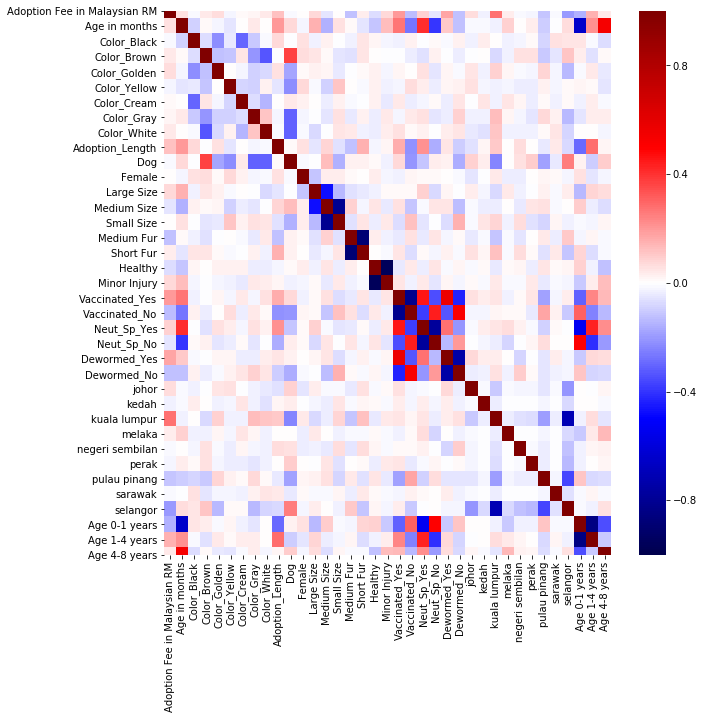

In [347]:
corr = shelter_dummy.corr()
#mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
#sns.heatmap(corr, cmap = 'seismic', mask = mask, annot = False, vmin = -1, vmax = 1, ax=ax)
sns.heatmap(corr, cmap = 'seismic', annot = False, vmin = -1, vmax = 1, ax=ax)

fig.savefig('Big_heatmap.jpg')

There is high correlation between some of the features related to pet condition, health, vaccination, dewarmed information, as well as pet sizs, fur length.

However, for the baseline model we will start with all of the features and gradually remove the features that are not statistically significant

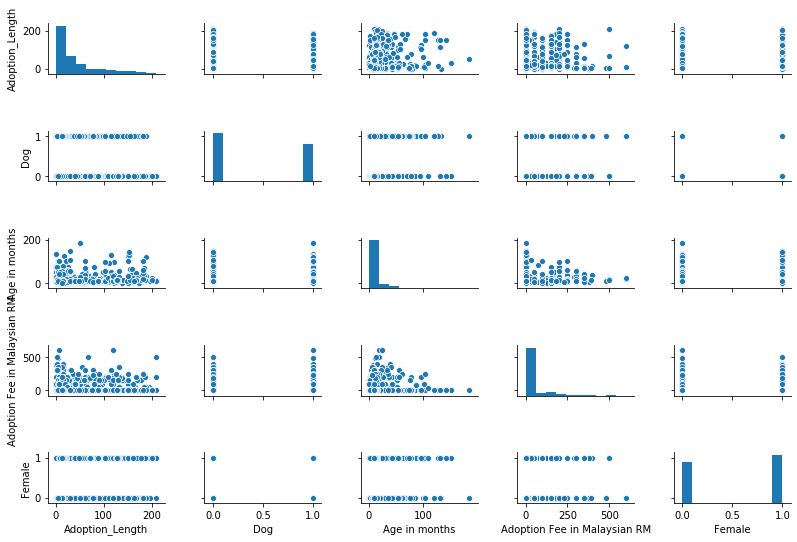

In [348]:
#sns.set(font_scale = 1)
sns.pairplot(shelter_dummy[['Adoption_Length', 
        'Dog','Age in months',  'Adoption Fee in Malaysian RM',
       'Female']],
             height = 1.5, aspect = 1.5)

plt.savefig('pairplot.jpg')

#### Modeling

In [349]:
# separate the data into hold out and train sets
X = shelter_dummy.drop(columns = ['Adoption_Length','Gender', 'Adoption_Length_categories', 'Cat_or_Dog','Age_category','Region_of_Country',
                                 'Condition', 'Dewormed', 'Vaccinated', 'Body Size', 'Fur length', 'Neutered_Spayed',
                                 'Pet Discription', 'Posted', 'Updated'])
y = shelter_dummy.loc[:, 'Adoption_Length']


In [350]:
def add_deviation_feature(X, feature, category):
    
    # temp groupby object
    category_gb = X.groupby(category)[feature]
    
    # create columns of category means and standard deviations
    category_mean = category_gb.transform(lambda x: x.mean())
    category_std = category_gb.transform(lambda x: x.std())
    
    # compute stds from category mean for each feature value,
    # add to X as new feature
    deviation_feature = (X[feature] - category_mean) / category_std 
    X[feature + '_Dev_' + category] = deviation_feature

In [351]:
X['Age_sqrt'] = np.sqrt(X['Age in months'])

In [352]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state = 42)

#### Baseline Model -- Linear Regression with all the existing features, no cross validation

For starters, we will apply Linear Regression to our training data without any feature engineering and see what we get for r2 and adjusted r2.

In [353]:
pet_model = sm.OLS(y_train,X_train)
results = pet_model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        Adoption_Length   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     6.075
Date:                Fri, 17 Apr 2020   Prob (F-statistic):           5.14e-24
Time:                        15:01:38   Log-Likelihood:                -4162.7
No. Observations:                 806   AIC:                             8399.
Df Residuals:                     769   BIC:                             8573.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Adoption Fee in Malaysian RM     0.0088      0.023      0.382      0.703      -0.036       0.054
Age in months                   -0.4021      0.519     -0.775      0.438      -1.420       0.616
Color_Black                      9.1579      3.553      2.577      0.010       2.183      16.133
Color_Brown                      3.1540      3.670      0.859      0.390      -4.050      10.358
Color_Golden                    11.2022      5.070      2.210      0.027       1.250      21.154
Color_Yellow                    -2.3709      5.900     -0.402      0.688     -13.952       9.210
Color_Cream                      0.3294      4.295      0.077      0.939      -8.102       8.760
Color_Gray                       0.8048      4.862      0.166      0.869      -8.740      10.350
Color_White                     -1.6265      3.581     -0.454      0.650      -8.656       5.404
Dog                             -2.5912      4.189     -0.619      0.536     -10.814       5.632
Female                           5.9078      3.163      1.868      0.062      -0.302      12.118
Large Size                      15.8115     31.818      0.497      0.619     -46.648      78.271
Medium Size                     28.7198     31.344      0.916      0.360     -32.811      90.250
Small Size                      22.5132     31.577      0.713      0.476     -39.475      84.501
Medium Fur                      13.1147      7.643      1.716      0.087      -1.890      28.119
Short Fur                       22.1973      7.345      3.022      0.003       7.779      36.615
Healthy                          9.5496     31.152      0.307      0.759     -51.604      70.703
Minor Injury                    18.9729     32.983      0.575      0.565     -45.775      83.721
Vaccinated_Yes                 -21.1558      8.863     -2.387      0.017     -38.555      -3.756
Vaccinated_No                  -31.7136      9.043     -3.507      0.000     -49.466     -13.961
Neut_Sp_Yes                     23.0567      6.861      3.360      0.001       9.588      36.525
Neut_Sp_No                      22.6774      6.010      3.773      0.000      10.879      34.476
Dewormed_Yes                     1.5730      8.166      0.193      0.847     -14.457      17.603
Dewormed_No                      4.4989      9.109      0.494      0.622     -13.383      22.380
johor                          -72.5708     59.036     -1.229      0.219    -188.461      43.319
kedah                          -37.3899     63.106     -0.592      0.554    -161.270      86.491
kuala lumpur                   -45.9118     57.665     -0.796      0.426    -159.111      67.288
melaka                         -56.5461     61.927     -0.913      0.361    -178.111      65.019
negeri sembilan                -18.2350     59.854     -0.305      0.761    

As we can see we get really low values for R2 and adjusted R2 for train results

Now let's use backward selection to remove one by one the features that are least statistically significant using p-values.

After removing the feature one by one we are left with the following features

In [354]:
mask = ['Age_sqrt', 'Color_Black',
      'Color_Golden', 'Female',
       'Medium Size', 'Medium Fur', 'Short Fur',
        'Vaccinated_Yes', 'Vaccinated_No', 'Neut_Sp_Yes',
       'Neut_Sp_No', 'johor',
        'selangor', 'Age 1-4 years']

In [355]:
pet_model = sm.OLS(y_train,X_train[mask])
results = pet_model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:        Adoption_Length   R-squared (uncentered):                   0.553
Model:                            OLS   Adj. R-squared (uncentered):              0.545
Method:                 Least Squares   F-statistic:                              69.94
Date:                Fri, 17 Apr 2020   Prob (F-statistic):                   6.18e-128
Time:                        15:01:38   Log-Likelihood:                         -4170.2
No. Observations:                 806   AIC:                                      8368.
Df Residuals:                     792   BIC:                                      8434.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Age_sqrt           4.8322      0.976      4.950      0.000       2.916       6.748
Color_Black        9.0894      3.128      2.906      0.004       2.949      15.230
Color_Golden      10.6707      4.557      2.342      0.019       1.725      19.616
Female             5.9771      3.054      1.957      0.051      -0.017      11.972
Medium Size        7.2206      3.550      2.034      0.042       0.252      14.189
Medium Fur        11.6733      6.188      1.886      0.060      -0.474      23.820
Short Fur         22.0427      5.715      3.857      0.000      10.825      33.261
Vaccinated_Yes   -19.7835      5.701     -3.470      0.001     -30.974      -8.593
Vaccinated_No    -29.8655      5.703     -5.237      0.000     -41.059     -18.672
Neut_Sp_Yes       22.0976      6.625      3.336      0.001       9.094      35.101
Neut_Sp_No        21.4961      5.569      3.860      0.000      10.564      32.428
johor            -29.2597     10.281     -2.846      0.005     -49.441      -9.079
selangor         -11.6698      3.172     -3.679      0.000     -17.896      -5.444
Age 1-4 years     23.8919      4.371      5.466      0.000      15.312      32.471
==============================================================================
Omnibus:                      144.666   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.912
Skew:                           1.126   Prob(JB):                     2.95e-53
Kurtosis:                       4.461   Cond. No.                         27.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We increased the R2 andadjusted R2 scores significantly for the train set, now let's check to see the test set R2

Next Let's try to use k-fold cross validation to train the linear regression model.

K-fold cross validation helps with overfitting.

We will use the features we found were significant

In [373]:
def train_model_cv(model, mask, regularize):
    '''This function fits a model into the data by doing cross validation'''
    # list to hold model evaluation scores for train set
    r2_list_tr = []
    rmse_list_tr = []
    # list to hold model evaluation scores for validation set
    r2_list_vl = []
    rmse_list_vl = []
    
    # split the data into k folds 
    kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
    
    for train_ind, val_ind in kf.split(X_train[mask], y_train):
        X_tr, y_tr = X_train[mask].iloc[train_ind], y_train.iloc[train_ind]
        X_vl, y_vl = X_train[mask].iloc[val_ind], y_train.iloc[val_ind]
        
        if regularize:
            # standard scaling 
            scaler = StandardScaler()

            X_tr_sc = X_tr.copy()
            X_vl_sc = X_vl.copy()

            scaled_col_X_tr = scaler.fit_transform(X_tr[['Age_sqrt']])
            X_tr_sc[['Age_sqrt']] = scaled_col_X_tr

            scaled_col_X_vl = scaler.transform(X_vl[['Age_sqrt']])
            X_vl_sc[['Age_sqrt']] = scaled_col_X_vl
        
        X_vl_sc = X_vl
        x_tr_sc = X_tr
        # train the model
        model.fit(x_tr_sc, y_tr)

        # append the train scores for each fold
        r2_list_tr.append(r2_score(y_tr, model.predict(x_tr_sc)))
        rmse_list_tr.append(np.sqrt(mean_squared_error(y_tr,model.predict(x_tr_sc))))

        # append the validation scores for each fold
        r2_list_vl.append(r2_score(y_vl, model.predict(X_vl_sc)))
        rmse_list_vl.append(np.sqrt(mean_squared_error(y_vl,model.predict(X_vl_sc))))

    # rmse for train and corss-validation
    print(f'Mean cross-validation r^2 (train): {np.mean(r2_list_tr):.3f}+-{np.std(r2_list_tr):.3f}')
    print(f'Mean cross-validation r^2 (validation): {np.mean(r2_list_vl):.3f}+-{np.std(r2_list_vl):.3f}')
    
    # rmse for train and cross-validation
    print(f'Mean cross-validation rmse (train): {np.mean(rmse_list_tr):.3f}+-{np.std(rmse_list_tr):.3f}')
    print(f'Mean cross-validation rmse (validation): {np.mean(rmse_list_vl):.3f}+-{np.std(rmse_list_vl):.3f}')
    
    return model

In [374]:
def train_model_after_cv(model, mask,regularize):
    '''This function train the model on the final train+val set, 
    after choosing the tuned parameter after doing cross validation'''
    X_tr_sc = X_train[mask]
    if regularize == True:
        scaler = StandardScaler()
        X_tr_sc = X_train[mask]
        scaled_col_X_tr = scaler.fit_transform(X_train[['Age_sqrt']])
        X_tr_sc[['Age_sqrt']] = scaled_col_X_tr
    

    # train
    model.fit(X_tr_sc, y_train)
    y_pred_train = model.predict(X_tr_sc)
    
    print('Train R2 score: ', r2_score(y_train, y_pred_train))
    return model


In [375]:
# do cross validation on linear regression
linear_reg_model = train_model_cv(LinearRegression(),mask, regularize = False)


Mean cross-validation r^2 (train): 0.210+-0.008
Mean cross-validation r^2 (validation): 0.173+-0.024
Mean cross-validation rmse (train): 42.642+-0.731
Mean cross-validation rmse (validation): 43.363+-2.966


Let's use regularization to try to imporve the train scores

In [376]:
for alpha in np.arange(1,10,1):
    print('Ridge Regression Results for alpha = ', alpha)
    ridge_model = train_model_cv(Ridge(alpha),mask, regularize = True)
    print('\n')

Ridge Regression Results for alpha =  1
Mean cross-validation r^2 (train): 0.209+-0.008
Mean cross-validation r^2 (validation): 0.174+-0.023
Mean cross-validation rmse (train): 42.646+-0.731
Mean cross-validation rmse (validation): 43.346+-2.968


Ridge Regression Results for alpha =  2
Mean cross-validation r^2 (train): 0.209+-0.008
Mean cross-validation r^2 (validation): 0.174+-0.023
Mean cross-validation rmse (train): 42.657+-0.731
Mean cross-validation rmse (validation): 43.339+-2.969


Ridge Regression Results for alpha =  3
Mean cross-validation r^2 (train): 0.209+-0.008
Mean cross-validation r^2 (validation): 0.174+-0.023
Mean cross-validation rmse (train): 42.672+-0.730
Mean cross-validation rmse (validation): 43.337+-2.971


Ridge Regression Results for alpha =  4
Mean cross-validation r^2 (train): 0.208+-0.008
Mean cross-validation r^2 (validation): 0.174+-0.022
Mean cross-validation rmse (train): 42.690+-0.730
Mean cross-validation rmse (validation): 43.341+-2.972


Ridge Re

Apply Ridge regression to train+val sets

In [377]:
ridge_model = train_model_after_cv(Ridge(alpha = 5), mask, regularize = True)

Train R2 score:  0.20534775603406374


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Let's try applying Lasso

In [378]:
for alpha in np.arange(0.001,1,.1):
    print('Lasso Regression Results for alpha = ', alpha)
    lasso_model = train_model_cv(Lasso(alpha),mask, regularize = True)
    print('\n')

Lasso Regression Results for alpha =  0.001
Mean cross-validation r^2 (train): 0.210+-0.008
Mean cross-validation r^2 (validation): 0.173+-0.024
Mean cross-validation rmse (train): 42.642+-0.731
Mean cross-validation rmse (validation): 43.363+-2.966


Lasso Regression Results for alpha =  0.101
Mean cross-validation r^2 (train): 0.208+-0.008
Mean cross-validation r^2 (validation): 0.173+-0.021
Mean cross-validation rmse (train): 42.681+-0.730
Mean cross-validation rmse (validation): 43.379+-3.007


Lasso Regression Results for alpha =  0.201
Mean cross-validation r^2 (train): 0.204+-0.008
Mean cross-validation r^2 (validation): 0.169+-0.020
Mean cross-validation rmse (train): 42.796+-0.728
Mean cross-validation rmse (validation): 43.477+-3.045


Lasso Regression Results for alpha =  0.30100000000000005
Mean cross-validation r^2 (train): 0.197+-0.008
Mean cross-validation r^2 (validation): 0.163+-0.020
Mean cross-validation rmse (train): 42.973+-0.721
Mean cross-validation rmse (validat

Apply the Lasso model with the tuned paramter to the train+val set

In [379]:
lasso_model = train_model_after_cv(Lasso(alpha = 0.001), mask, regularize = True)

Train R2 score:  0.20705374072324545


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Computing regularization path using the LARS ...


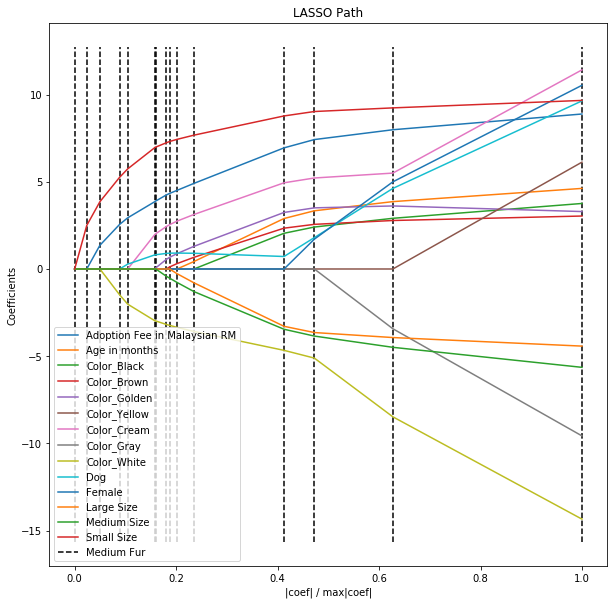

In [388]:
## Scale the variables
std = StandardScaler()
std.fit(X_train[mask].values)

X_tr = std.transform(X_train[mask].values)

print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(X_tr, y_train.values, method='lasso')

# plotting the LARS path

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_train.columns)
plt.show()

None of the models gave good results on train/val sets. Now let's check the final test set scores

In [393]:
scaler = StandardScaler()
X_test_sc = X_test[mask].copy()
scaled_col_X_test = scaler.fit_transform(X_test[['Age_sqrt']])
X_test_sc[['Age_sqrt']] = scaled_col_X_test
# predict the y_test_pred
lr_pred = linear_reg_model.predict(X_test_sc)
rr_pred = ridge_model.predict(X_test_sc)
ls_pred = lasso_model.predict(X_test_sc)

# calculate the metrics
print('RMSE for Linear Regression:',np.sqrt(mean_squared_error(y_test, lr_pred)))
print('RMSE for Ridge Regression:',np.sqrt(mean_squared_error(y_test, rr_pred)))
print('RMSE for Lasso Regression:',np.sqrt(mean_squared_error(y_test, ls_pred)))

print('R2 for Linear Regression:',r2_score(y_test, lr_pred))
print('R2 for Ridge Regression:',r2_score(y_test, rr_pred))
print('R2 for Lasso Regression:',r2_score(y_test, ls_pred))

RMSE for Linear Regression: 51.043055649249524
RMSE for Ridge Regression: 45.82242823215458
RMSE for Lasso Regression: 46.05514181029324
R2 for Linear Regression: -0.035111313835589186
R2 for Ridge Regression: 0.16580050127976853
R2 for Lasso Regression: 0.15730586184366457


The test results for Ridge and Lasso are much closer to the train/val scores, however, for Linear Regression test scores we got negative R2, which means the Linear Regression is doing much much worse

Let's check some of the assumptions of Linear Regression:


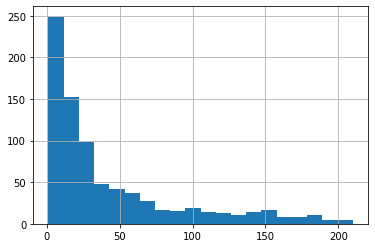

In [380]:
y_train.hist(bins =20)

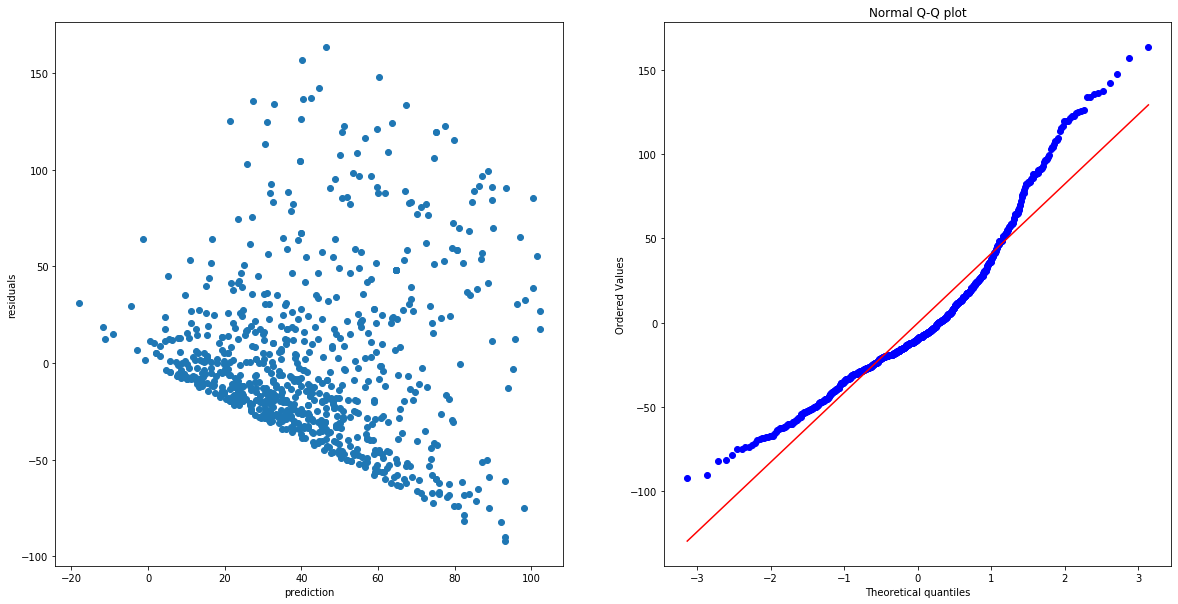

In [381]:
# plot the residulas and Q-Q plot
plt.figure(figsize = (20,10))
plt.subplot(1,2,1)
res = y_train - linear_reg_model.predict(X_train[mask])
plt.scatter(linear_reg_model.predict(X_train[mask]), res)
plt.xlabel('prediction')
plt.ylabel('residuals')

plt.subplot(1,2,2)
stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show()

As we can see the residuals are not normally distributed, the residual plot doesn't look random and symmetric. The Q-Q plot shows the distribution is skewed.

The number of days which we are trying to predict can't be negative and can also be only integer valued, so it is not really countinuous. 

The relationship between the features and the target variable is not linear so linear regression is having a hard time of predicting it.


Unfortunately, none of the regression models gave us good results. As we also saw that Linear regression assumptions were not satisfied. 

In the future I plan to:
* apply non linear models and see if I can imporve the results
* use NLP to analyize the pet descriptions to see if that could help with increasing the model accuracy
* scrape the actual pictures of the pets and use that in the prediction since I think picture of the pet is one of the important factors of pet adoption
* approach this as a classification problem instead of regression
* optimize the code
